# Calculating Single Base Accuracy

## import & function define

In [32]:
import os, tqdm, subprocess, random, tempfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from itertools import product
from matplotlib.colors import LinearSegmentedColormap

In [33]:
def read_reference_sequences(refer_path):
    return [str(item.seq) for idx, item in enumerate(SeqIO.parse(refer_path, 'fasta'))]

def get_motifs(base_alphabet, step):
    return [''.join(_) for _ in product(base_alphabet, repeat=step)]

def align_sequences(query, ref, step, base_alphabet, motifs):
    error_type_array = np.zeros((len(base_alphabet) ** step, len(base_alphabet) ** step))

    with tempfile.NamedTemporaryFile(mode='w+', delete=False, suffix='.fasta') as temp_in, \
         tempfile.NamedTemporaryFile(mode='r', delete=False, suffix='.fasta') as temp_out:
        
        temp_in.write(f'>query\n{query}\n>ref\n{ref}\n')
        temp_in.flush()

        with open(os.devnull, 'w') as devnull:
            subprocess.run(
                f'muscle -align {temp_in.name} -output {temp_out.name}',
                shell=True, stdout=devnull, stderr=devnull, check=True
            )

        temp_out.seek(0)
        aligned_query, aligned_ref = '', ''
        for record in SeqIO.parse(temp_out.name, 'fasta'):
            if record.id == 'query':
                aligned_query = str(record.seq)
            elif record.id == 'ref':
                aligned_ref = str(record.seq)

    os.remove(temp_in.name)
    os.remove(temp_out.name)

    for i in range(len(aligned_ref) - step + 1):
        a, b = aligned_query[i:i+step], aligned_ref[i:i+step]
        if a in motifs and b in motifs:
            error_type_array[motifs.index(a), motifs.index(b)] += 1

    return error_type_array

def calculate_error_rates(queries, refs, motifs, max_sample_num, step, base_alphabet):
    assert len(queries) == len(refs), "The number of query sequences must match the number of reference sequences."
    assert len(queries) > 0, "The query sequences list is empty."
    assert len(refs) > 0, "The reference sequences list is empty."
    assert max_sample_num > 0, "The maximum sample number must be greater than 0."
    
    calculating_info = pd.DataFrame(columns=['seq_index', 'copy_index'] + [f'{i[0]}>{i[1]}' for i in product(motifs, repeat=2)])
    
    with tqdm.trange(len(refs), desc='Calculating error rate...') as pbar:
        for idx, (query, ref) in enumerate(zip(queries, refs)):
                error_type_array = align_sequences(query, ref, step, base_alphabet, motifs)
                temp_dict = {'seq_index': idx}
                for row in range(error_type_array.shape[0]):
                    for column in range(error_type_array.shape[1]):
                        temp_dict[f'{motifs[row]}>{motifs[column]}'] = error_type_array[row, column]
                
                calculating_info = pd.concat([calculating_info, pd.DataFrame(temp_dict, index=[0])], ignore_index=True)
            
                pbar.update()
    
    calculating_info.fillna(0, inplace=True)
    return calculating_info

def create_confusion_matrix(calculating_info, base_alphabet, step, skip_diagonal=True, normalize='column'):
    all_type_error = calculating_info.sum(numeric_only=True)[2:]
    size = len(base_alphabet) ** step
    error_type_array = np.zeros((size, size))

    for idx, error_value in enumerate(all_type_error):
        row = idx // size
        col = idx % size
        if skip_diagonal and row == col:
            continue
        error_type_array[row, col] = error_value

    with np.errstate(divide='ignore', invalid='ignore'):
        if normalize == 'row':
            row_sums = np.sum(error_type_array, axis=1, keepdims=True)
            error_type_array = np.divide(error_type_array * 100, row_sums, where=row_sums != 0)
        elif normalize == 'column':
            col_sums = np.sum(error_type_array, axis=0, keepdims=True)
            error_type_array = np.divide(error_type_array * 100, col_sums, where=col_sums != 0)
        elif normalize == 'all':
            total = np.sum(error_type_array)
            if total > 0:
                error_type_array = error_type_array * 100 / total
        elif normalize is None:
            pass
        else:
            raise ValueError("normalize must be one of: 'row', 'column', 'all', or None")

    return error_type_array


def plot_heatmap(confusion_matrix, motifs, colors, output_file, need_save = False):
    df_cm = pd.DataFrame(confusion_matrix.T, index=motifs, columns=motifs)
    # np.fill_diagonal(df_cm.values, np.nan)

    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

    plt.figure(figsize=(5, 5))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', cmap=custom_cmap, annot_kws={"size": 12}, cbar_kws={'label': 'Substitution (%)'})

    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(12)
    cbar.ax.tick_params(labelsize=12)

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Substitution', fontsize=12)
    plt.ylabel('Reference', fontsize=12)
    plt.tight_layout()
    plt.savefig(output_file) if need_save else None
    plt.show()

## read csv

In [34]:
import pandas as pd

data_df = pd.read_csv('polyT_reads_with_length_diff_bcd06_total_250401_calls_with_bonito_10.4.1@hac.csv')
# remove the row if it contains 'nan' in the 'PolyT_Length_Difference' column or 'PolyT_Length_Ground_Truth' column
data_df = data_df.dropna(subset=['PolyT_Length_Difference', 'PolyT_Length_Ground_Truth'])

In [35]:
# Randomly choose a subset of 1000 rows
random_seed = 114514
subset_df = data_df.sample(n=1000, random_state=random_seed)
subset_df = subset_df.reset_index(drop=True)

In [36]:
subset_df

,Query_Name,Reference_Name,Query_Sequence,Reference_Sequence,PolyT_Length_Difference,PolyT_Length_Ground_Truth
0,408552b0-a498-473b-86a2-37ee49185902,chr9,TAGATGTGTATAAGAGACAGGAGGAAGACCATCTTGCCTTCAGTTG...,GAGGAAGACCATCTTGCCTTCATTGAGATGAAAATTTACACAAATC...,0.0,5.0
1,e75c8a58-bc3f-4481-ba3c-400526b10097,chrX,ACACTGCTTCGAGCATACATTATTGCTAAGGTTAGAGCTCTTCTGC...,CCTCTCTTTTTGCCAAGATTAAAATCATTTCCTATTGATGCCATCA...,0.0,5.0
2,1b5b1a0b-0efe-4411-a478-468020122cd8,chr1,TGACAGGGCCTGACAGCTCACTGCAGCCTGAACCTCCCAGGCTCAA...,CAGGCCTGGGAGCCCGCCGTCTGCTAGTAAGGGGCTTCAGGAGTTG...,0.0,5.0
3,69ce3aa9-9b2b-4c87-8db5-19b2b375c025,chr5,TGTAACGGACCGCAGGCTTACATTAAATTGACTAAAAATTGGGCAC...,GTTTTGTTTACTAATATTTTATAATAAGCAAATTACCATCCTGCCT...,0.0,5.0
4,2d91a31a-693d-4c61-97b5-db7b7a9426da,chr1,ATTGTGAAGGTTAAGACTACTTTCTGCCTTTGCGAGAACAGCACCT...,CTGCCTCAACTGTGTTATATTAGTAAAGTGGAGGAGGGCAAAAAAA...,0.0,6.0
...,...,...,...,...,...,...
995,68d07151-f081-488d-bc03-66ad36244fa5,chrX,ACTGATTGTAAGGTTAAGACTACTTTCTGCCTTTGCGAGACACACC...,TCTTACTGCTTCATGGAAGAGTGGAAAGAACAAAGGATTAACAGCC...,0.0,6.0
996,dc30ce6c-e84e-41bd-bfbf-322e3c120bbd,chr16,ACCATCGTGAAGCGTAGCACTACTTCTGCCTTTGTGAACAGCACCT...,ACCTATTTCAAGACCTAAAAAATGTCTTGTTCATTGCAGAGTCTCA...,0.0,5.0
997,2846897f-42f5-404f-a73d-d1d674aa22e1,chrX,ACGCATCGCTAAGGTTAGACCGACTCTCGCCTTTGCGAGAACAGCA...,AGACAGTTAAATGTTTTTCCTCATTTCCTAAAGGAAATGTCTGCAT...,0.0,7.0
998,0f8ae9de-3087-4eee-b47d-3d897ae650d2,chr2,TACTTACTGGTTCAGTTACGTATTGCTAAGGTTAAGACTACTTCTC...,GAAAAGGAGAAATAAAAAGTTTTCCACGTCCTCTGACAGGAGCCCA...,0.0,5.0


In [37]:
queries = subset_df['Query_Sequence'].astype(str).tolist()
refs = subset_df['Reference_Sequence'].astype(str).tolist()

In [38]:
STEP = 1
base_alphabet = 'ACGT'
motifs = get_motifs(base_alphabet, STEP)
calculating_info = calculate_error_rates(queries, refs, motifs, max_sample_num=1000, step=STEP, base_alphabet=base_alphabet)

Calculating error rate...: 100%|██████████| 1000/1000 [00:30<00:00, 33.22it/s]


[[86.74064226  3.14175362  4.93855651  2.64785724]
 [ 3.32037908 87.04098691  3.54237581  4.96936793]
 [ 6.13622418  3.6461636  87.76034155  2.98903772]
 [ 3.80275448  6.17109587  3.75872613 89.39373711]]


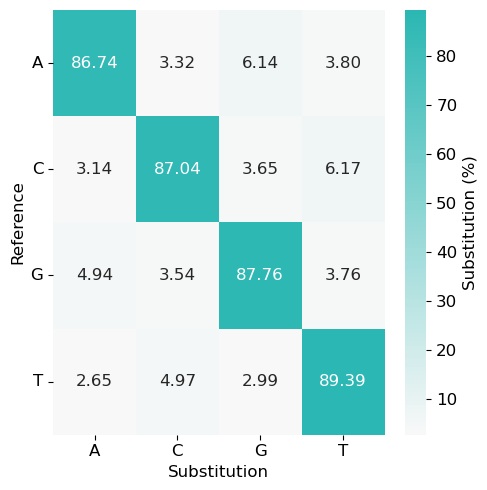

In [39]:
confusion_matrix = create_confusion_matrix(calculating_info, base_alphabet, STEP, skip_diagonal=False)
print(confusion_matrix)
orange = ["#f8f8f8", "#ED6C00"]
azure = ["#f8f8f8", "#2BB7B3"]
darkgreen = ["#f8f8f8", "#003F43"]
plot_heatmap(confusion_matrix, motifs, azure, './', need_save=False)